<a href="https://colab.research.google.com/github/JerKeller/MP-Ecotaxa/blob/main/Variabilty_ecotaxa_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import libraries, dataset, extract colums needed

In [3]:
# Importing libraries
import pandas as pd
import numpy as np
import os
import sys
import subprocess
from plotnine import ggplot, aes, geom_point, geom_line, labs, ggtitle, scale_y_log10
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
from google.colab import drive

In [5]:
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
ecotaxa_export = '/content/drive/MyDrive/Ecotaxa_analysis/ecotaxa_export.tsv'
tsv_read = pd.read_csv(ecotaxa_export, sep='\t')

Extract columns needed

In [7]:
sub1 = tsv_read[['object_id', 'object_date', 'object_depth_min', 'object_depth_max', 'object_annotation_category',
                 'object_area', 'object_area_exc', 'object_major', 'object_minor', 'sample_tot_vol', 'process_particle_pixel_size_mm',
                 'acq_id']]

Modify names of columns

In [8]:
sub1.columns = ['Label', 'Date', 'Min_depth', 'Max_depth', 'Taxa', 'area', 'areaExc', 'major', 'minor',
                'Tow_Vol', 'pixel_size_mm', 'acq_id']

Remove not living organisms

In [9]:
sub2 = sub1[(sub1['Taxa'] != 'badfocus<artefact') & (sub1['Taxa'] != 'fiber<detritus') & 
            (sub1['Taxa'] != 'multiple<other') & (sub1['Taxa'] != 'detritus') & 
            (sub1['Taxa'] != 'egg sac<egg') & (sub1['Taxa'] != 't001') & 
            (sub1['Taxa'] != 't002') & (sub1['Taxa'] != 't003') & 
            (sub1['Taxa'] != 'othertocheck') & (sub1['Taxa'] != 'artefact') & 
            (sub1['Taxa'] != 'bubble') & (sub1['Taxa'] != 'dead<Copepoda')].copy()


## Stratif water column analysis

Exclude samples not needed yet

In [10]:
substrat = sub2[~sub2['acq_id'].isin(['tot_n10_221027', 'tot_n9_221013', 'tot_n14_221103',
                                           'tot_n19_221110', 'tot_n24_221221', 'tot_n25_221221',
                                           'tot_n26_221221', 'tot_n27_221221', 'tot_n28_221221',
                                           'tot_n29_221221','tot_n32_230105','tot_n35_230118',
                                          'tot_n38_230209','tot_n41_230209','tot_n42_230209',
                                          'tot_n43_230216','tot_n46_230222'])].copy()

Date format

In [11]:
substrat['Date'] = pd.to_datetime(substrat['Date'], format='%Y%m%d')

Conversions from pixel to mm

In [12]:
# Conversions from pixel to mm
substrat['Area_mm2'] = substrat['area'] * ((substrat['pixel_size_mm']) ** 2)
substrat['AreaExc_mm2'] = substrat['areaExc'] * ((substrat['pixel_size_mm']) ** 2)
substrat['Major_mm'] = substrat['major'] * substrat['pixel_size_mm']
substrat['Minor_mm'] = substrat['minor'] * substrat['pixel_size_mm']

Ellipsoidal Volume = V (mm3) = 4/3 x ∏ x [ (Major(mm)/2) x (Minor(mm)/2) x (Minor(mm)/2) ]

In [13]:
substrat['V_mm3'] = (4 / 3) * np.pi * ((substrat['Major_mm'] / 2) * (substrat['Minor_mm'] / 2) * (substrat['Minor_mm'] / 2))

In [ ]:
print(substrat)

                     Label       Date  Min_depth  Max_depth  \
1443    n11_221027_tot_1_1 2022-10-27        0.0      100.0   
1445    n11_221027_tot_1_3 2022-10-27        0.0      100.0   
1446    n11_221027_tot_1_6 2022-10-27        0.0      100.0   
1447    n11_221027_tot_1_7 2022-10-27        0.0      100.0   
1448    n11_221027_tot_1_8 2022-10-27        0.0      100.0   
...                    ...        ...        ...        ...   
23282  n8_221013_tot_1_641 2022-10-13        0.0       50.0   
23283  n8_221013_tot_1_642 2022-10-13        0.0       50.0   
23284  n8_221013_tot_1_643 2022-10-13        0.0       50.0   
23287  n8_221013_tot_1_646 2022-10-13        0.0       50.0   
23288  n8_221013_tot_1_647 2022-10-13        0.0       50.0   

                       Taxa    area  areaExc  major  minor  Tow_Vol  \
1443   Eudiaptomus gracilis  2159.0   2159.0   58.3   47.2   7.0686   
1445   Eudiaptomus gracilis  2621.0   2616.0  109.9   30.4   7.0686   
1446     Cyclops prealpinus  5

Creates a factor which allows binning by the log of the biovolume

In [12]:
substrat['logvol'] = np.log10(substrat['V_mm3'])

Create groups based on acq_id, taxa and date

In [14]:
grouped_data = substrat.groupby(['Date','acq_id','Taxa'])

In [ ]:
print(grouped_data)

In [15]:
species_count_data = grouped_data.agg({'Taxa': 'count', 'Tow_Vol': 'mean'}).rename(columns={'Taxa': 'Count', 'Tow_Vol': 'tv'})

In [16]:
species_count_data.to_excel('species_count_data.xlsx', index=False)

In [49]:
print(species_count_data)

                                                Count      tv
Date       acq_id         Taxa                               
2022-09-06 tot_n1_220906  Cyclops prealpinus      235  5.6549
                          Daphnia<Daphniidae       12  5.6549
                          Eubosmina sp              7  5.6549
                          Eudiaptomus gracilis     30  5.6549
                          Leptodora kindtii         1  5.6549
...                                               ...     ...
2023-02-22 tot_n47_230222 nauplii<Copepoda          1  3.5343
           tot_n48_230222 Cyclops prealpinus      112  3.5343
                          Daphnia<Daphniidae        5  3.5343
                          Eudiaptomus gracilis    370  3.5343
                          nauplii<Copepoda         35  3.5343

[161 rows x 2 columns]


In [17]:
concentration_data = species_count_data.copy()
concentration_data.reset_index(inplace=True)

In [18]:
concentration = concentration_data.groupby(["Date", "Taxa"], as_index=False).agg({"Count": "sum", "tv": "sum"})


In [19]:
concentration['Concentration'] = concentration['Count'] / concentration['tv']

In [20]:
print(concentration)

         Date                  Taxa  Count      tv  Concentration
0  2022-09-06    Cyclops prealpinus    260  7.0686      36.782390
1  2022-09-06    Daphnia<Daphniidae     44  7.0686       6.224712
2  2022-09-06          Eubosmina sp     11  7.0686       1.556178
3  2022-09-06  Eudiaptomus gracilis     73  7.0686      10.327363
4  2022-09-06     Leptodora kindtii      5  7.0686       0.707354
..        ...                   ...    ...     ...            ...
87 2023-02-16      nauplii<Copepoda     26  7.0686       3.678239
88 2023-02-22    Cyclops prealpinus    127  7.0686      17.966783
89 2023-02-22    Daphnia<Daphniidae      7  7.0686       0.990295
90 2023-02-22  Eudiaptomus gracilis    399  7.0686      56.446821
91 2023-02-22      nauplii<Copepoda     36  7.0686       5.092946

[92 rows x 5 columns]


In [98]:
concentration.to_excel('concentration.xlsx', index=False)

Total biovolume and concentration by sample

In [21]:
total_conc = concentration.groupby('Date').agg({'Count': 'sum', 'Concentration': 'sum'}).reset_index()

In [22]:
print(total_conc)

         Date  Count  Concentration
0  2022-09-06    403      57.012704
1  2022-09-13   1725     244.037009
2  2022-09-20    933     141.612371
3  2022-10-13    516      73.281838
4  2022-10-27   1077     152.363976
5  2022-11-03    862     122.655123
6  2022-11-08    693      98.322157
7  2022-11-10    494      73.140367
8  2022-12-02    416      58.851824
9  2022-12-21    703     109.216680
10 2023-01-05    785     113.885629
11 2023-01-18    870     123.083017
12 2023-02-01    409      60.551186
13 2023-02-09    832      78.707110
14 2023-02-16    499      70.735365
15 2023-02-22    569      80.496845


In [ ]:
cyclopsEudia = ["Cyclops prealpinus","Eudiaptomus gracilis","nauplii<Copepoda"]
concentration_data_cyclops = concentration_data.query('Taxa in @cyclopsEudia')

DaphEubos = ["Daphnia<Daphniidae","Eubosmina sp"]
concentration_data_daph = concentration_data.query('Taxa in @DaphEubos')

LeptoBitho = ["Leptodora kindtii","Bythotrephes longimanus",]
concentration_data_lepto = concentration_data.query('Taxa in @LeptoBitho')

In [ ]:
grouped_conc_data = concentration_data.groupby(['Taxa', 'Date'])['Concentration'].sum().reset_index()

In [ ]:
group_cyclopsEudia = ["Cyclops prealpinus","Eudiaptomus gracilis","nauplii<Copepoda"]
grouped_data_cyclops = grouped_conc_data.query('Taxa in @group_cyclopsEudia')

group_dapheubo = ["Daphnia<Daphniidae","Eubosmina sp"]
grouped_data_dapheubo = grouped_conc_data.query('Taxa in @group_dapheubo')

group_leptobitho = ["Leptodora kindtii","Bythotrephes longimanus"]
grouped_data_leptobitho = grouped_conc_data.query('Taxa in @group_leptobitho')

### Plots

Total concentration plot

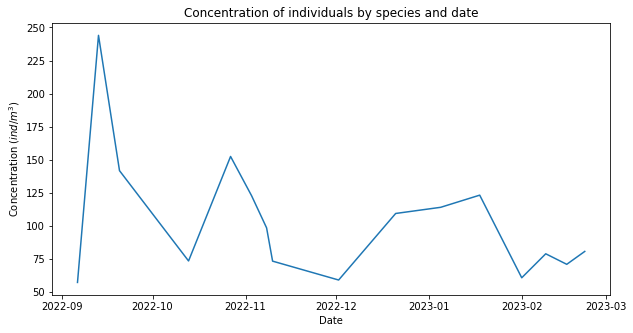

In [23]:
plt.figure(figsize=(10, 5))
sns.lineplot(x="Date", y="Concentration", data=total_conc, markers=True, ci=None)
plt.title("Concentration of individuals by species and date")
plt.xlabel("Date")
plt.ylabel("Concentration ($ind/m^3$)")
plt.show()

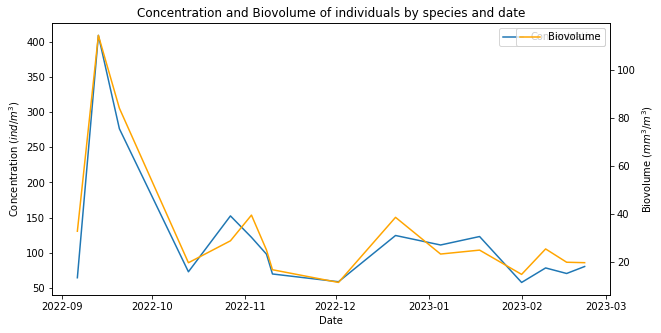

In [ ]:
fig, ax1 = plt.subplots(figsize=(10, 5))

# plot the first variable (Concentration) on the left y-axis
sns.lineplot(x="Date", y="Concentration", data=total_conc, markers=True, ax=ax1, ci=None, label = "Concentration")
ax1.set_xlabel('Date')
ax1.set_ylabel('Concentration ($ind/m^3$)')


ax2 = ax1.twinx()


sns.lineplot(x="Date", y="Biovolume", data=total_conc, markers=True, ax=ax2, color='orange', ci=None, label = "Biovolume")
ax2.set_ylabel('Biovolume ($mm^3/m^3$)')

plt.title("Concentration and Biovolume of individuals by species and date")
plt.legend()
plt.show()







Concentration by taxa

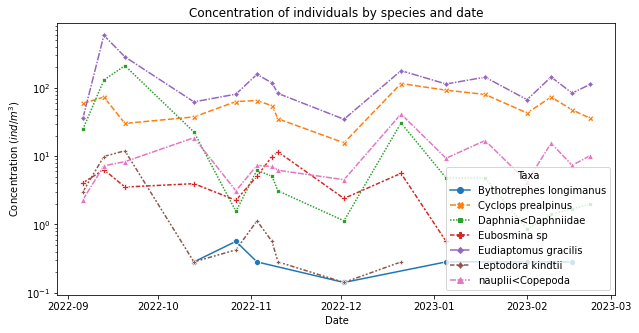

In [ ]:
plt.figure(figsize=(10, 5))
sns.lineplot(x="Date", y="Concentration", hue="Taxa", data=grouped_conc_data, style="Taxa", markers=True)
plt.yscale("log") # add logarithmic scale
plt.title("Concentration of individuals by species and date")
plt.xlabel("Date")
plt.ylabel("Concentration ($ind/m^3$)")
plt.show()

Biovolume for Cyclops, eudiaptomus and nauplii

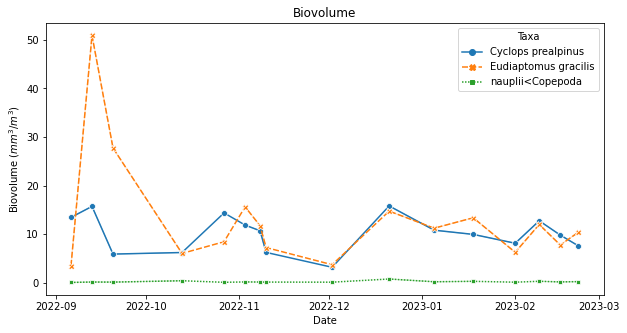

In [ ]:
plt.figure(figsize=(10, 5))
sns.lineplot(x="Date", y="Biovolume", hue="Taxa", data=concentration_data_cyclops, style="Taxa", markers=True)
#plt.yscale("log") # add logarithmic scale
plt.title("Biovolume")
plt.xlabel("Date")
plt.ylabel("Biovolume ($mm^3$/$m^3$)")
plt.show()

Concentration for cyclops, eudiaptomus and nauplii

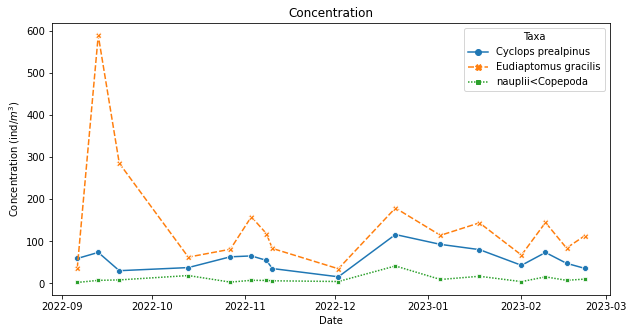

In [ ]:
plt.figure(figsize=(10, 5))
sns.lineplot(x="Date", y="Concentration", hue="Taxa", data=grouped_data_cyclops, style="Taxa", markers=True)
#plt.yscale("log") # add logarithmic scale
plt.title("Concentration")
plt.xlabel("Date")
plt.ylabel("Concentration (ind/$m^3$)")
plt.show()

Biovolume for daphnia and eubosmina

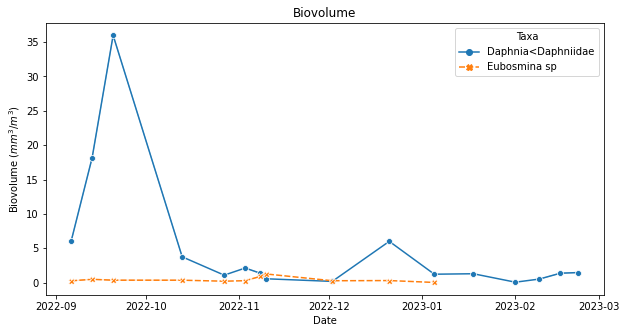

In [ ]:
plt.figure(figsize=(10, 5))
sns.lineplot(x="Date", y="Biovolume", hue="Taxa", data=concentration_data_daph, style="Taxa", markers=True)
#plt.yscale("log") # add logarithmic scale
plt.title("Biovolume")
plt.xlabel("Date")
plt.ylabel("Biovolume ($mm^3$/$m^3$)")
plt.show()

Concentration for daphnia and eubosmina

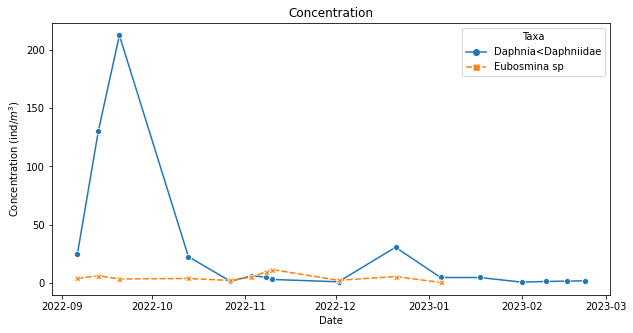

In [ ]:
plt.figure(figsize=(10, 5))
sns.lineplot(x="Date", y="Concentration", hue="Taxa", data=grouped_data_dapheubo, style="Taxa", markers=True)
#plt.yscale("log") # add logarithmic scale
plt.title("Concentration")
plt.xlabel("Date")
plt.ylabel("Concentration (ind/$m^3$)")
plt.show()

Biovolume for bythotrephes and leptodora

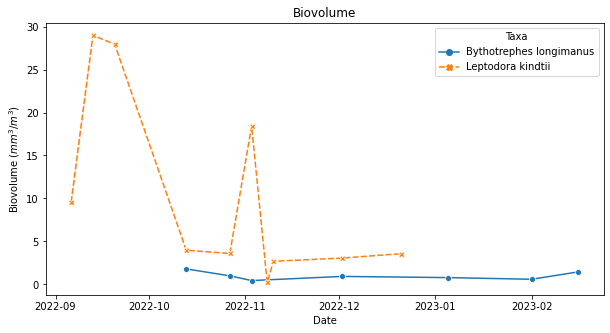

In [ ]:
plt.figure(figsize=(10, 5))
sns.lineplot(x="Date", y="Biovolume", hue="Taxa", data=concentration_data_lepto, style="Taxa", markers=True)
#plt.yscale("log") # add logarithmic scale
plt.title("Biovolume")
plt.xlabel("Date")
plt.ylabel("Biovolume ($mm^3$/$m^3$)")
plt.show()

Concentration for bythotrephes and leptodora

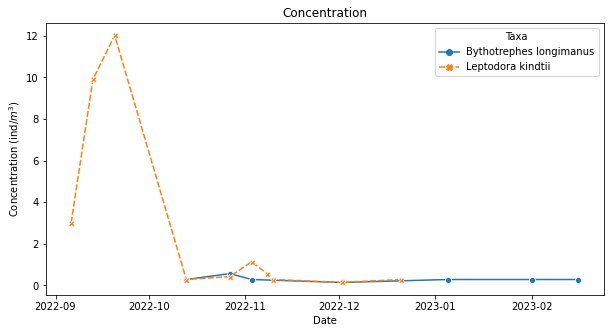

In [ ]:
plt.figure(figsize=(10, 5))
sns.lineplot(x="Date", y="Concentration", hue="Taxa", data=grouped_data_leptobitho, style="Taxa", markers=True)
#plt.yscale("log") # add logarithmic scale
plt.title("Concentration")
plt.xlabel("Date")
plt.ylabel("Concentration (ind/$m^3$)")
plt.show()

In [ ]:
species_to_plot = ["cyclops préalpinus", "eudiaptomus gracilis"]
concentration_data_filtered = concentration_data.query('Taxa in @species_to_plot')

In [ ]:
grouped_conc_data = grouped_conc_data.sort_values(by='Date')

In [ ]:
grouped_conc_data['Date'] = grouped_conc_data['Date'].dt.date

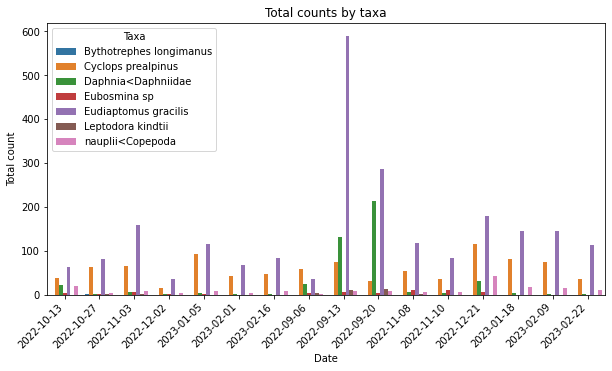

In [ ]:
plt.figure(figsize=(10,5))
sns.barplot(x="Date", y="Concentration",hue="Taxa", data=grouped_conc_data, ci=None)
plt.title("Total counts by taxa")
plt.xlabel("Date")
plt.ylabel("Total count")
plt.xticks(rotation=45, ha='right')
plt.show()

In [ ]:
concentration_data = concentration_data.sort_values(by='Date')



<Figure size 720x360 with 0 Axes>

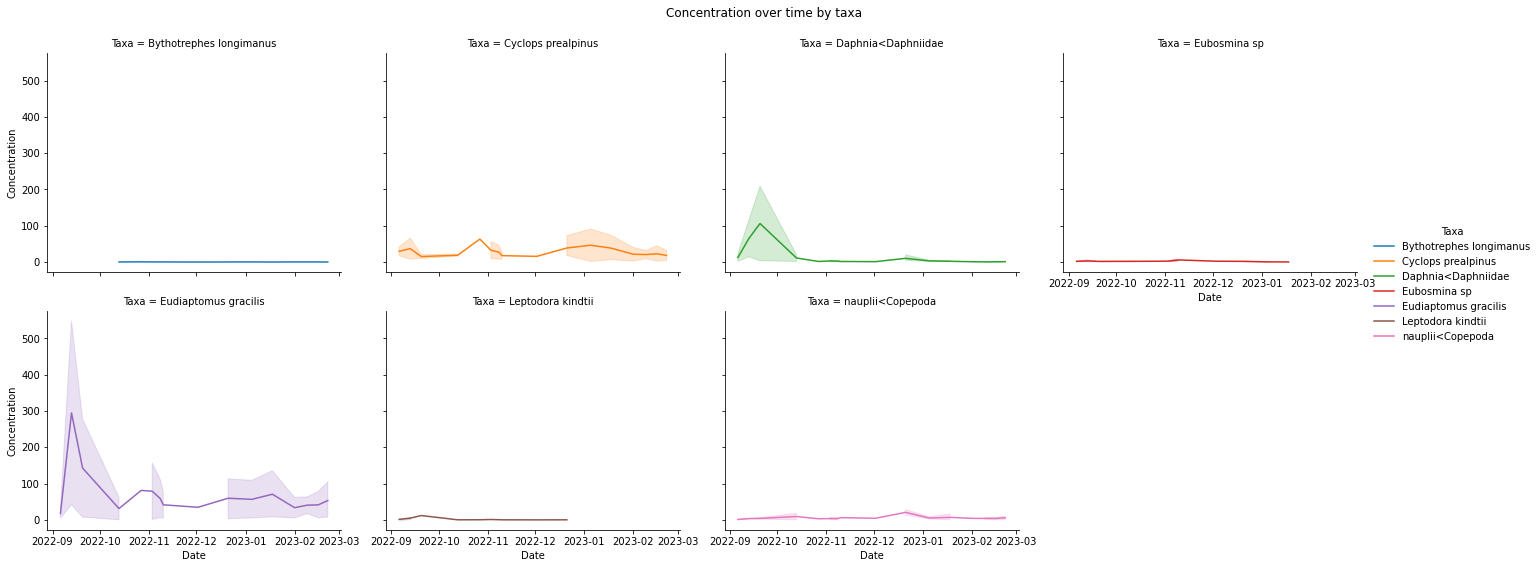

In [ ]:
plt.figure(figsize=(10,5))
sns.relplot(x="Date", y="Concentration", hue="Taxa", kind="line", col="Taxa", col_wrap=4, data=concentration_data, height=4, aspect=1.2)
plt.subplots_adjust(top=0.9)
plt.suptitle("Concentration over time by taxa")
plt.show()

## 100-0 water column analysis

In [24]:
sub100 = sub2[sub2['acq_id'].isin(['tot_n10_221027', 'tot_n9_221013', 'tot_n14_221103',
                                           'tot_n19_221110', 'tot_n24_221221', 'tot_n25_221221',
                                           'tot_n26_221221','tot_n32_230105','tot_n35_230118',
                                          'tot_n38_230209',
                                          'tot_n43_230216','tot_n46_230222'])].copy()

In [25]:
sub100['Date'] = pd.to_datetime(sub100['Date'], format='%Y%m%d')

In [26]:
sub100['Area_mm2'] = sub100['area'] * ((sub100['pixel_size_mm']) ** 2)
sub100['AreaExc_mm2'] = sub100['areaExc'] * ((sub100['pixel_size_mm']) ** 2)
sub100['Major_mm'] = sub100['major'] * sub100['pixel_size_mm']
sub100['Minor_mm'] = sub100['minor'] * sub100['pixel_size_mm']

In [27]:
sub100['V_mm3'] = (4 / 3) * np.pi * ((sub100['Major_mm'] / 2) * (sub100['Minor_mm'] / 2) * (sub100['Minor_mm'] / 2))

In [28]:
grouped_data100 = sub100.groupby(['acq_id', 'Taxa', 'Date'])

In [29]:
species_count_data100 = grouped_data100.agg({'Taxa': 'count', 'Tow_Vol': 'mean'}).rename(columns={'Taxa': 'Count', 'Tow_Vol': 'tv'})

In [30]:
concentration_data100 = species_count_data100.copy()
concentration_data100['Concentration'] = concentration_data100['Count'] / concentration_data100['tv']
concentration_data100.reset_index(inplace=True)

In [31]:
biovolume_data100 = sub100.groupby(['Taxa', 'Date']).agg({'Tow_Vol': 'mean', 'V_mm3': 'sum'})
biovolume_data100['Biovolume'] = biovolume_data100['V_mm3'] / biovolume_data100['Tow_Vol']
biovolume_data100.reset_index(inplace=True)

concentration_data100 = concentration_data100.merge(biovolume_data100[['Taxa', 'Date','Biovolume']], on=['Taxa', 'Date'])

In [32]:
total_conc100 = concentration_data100.groupby('acq_id').agg({'Count': 'sum', 'Concentration': 'sum', 'Biovolume': 'sum','Date': 'first'}).reset_index()

In [33]:
total_conc100 = total_conc100.drop('acq_id', axis=1)

In [34]:
total_conc100 = total_conc100.groupby('Date').sum().reset_index()

In [35]:
date_column = total_conc100.pop("Date")
total_conc100.insert(0, "Date", date_column)

In [ ]:
total_conc100.to_excel('total_conc100.xlsx', index=False)

In [ ]:
cyclopsEudia100 = ["Cyclops prealpinus","Eudiaptomus gracilis","nauplii<Copepoda"]
concentration_data_cyclops100 = concentration_data100.query('Taxa in @cyclopsEudia')

DaphEubos100 = ["Daphnia<Daphniidae","Eubosmina sp"]
concentration_data_daph100 = concentration_data100.query('Taxa in @DaphEubos')

LeptoBitho100 = ["Leptodora kindtii","Bythotrephes longimanus",]
concentration_data_lepto100 = concentration_data100.query('Taxa in @LeptoBitho')

In [ ]:
grouped_conc_data100 = concentration_data100.groupby(['Taxa', 'Date'])['Concentration'].sum().reset_index()

In [ ]:
group_cyclopsEudia100 = ["Cyclops prealpinus","Eudiaptomus gracilis","nauplii<Copepoda"]
grouped_data_cyclops100 = grouped_conc_data100.query('Taxa in @group_cyclopsEudia')

group_dapheubo100 = ["Daphnia<Daphniidae","Eubosmina sp"]
grouped_data_dapheubo100 = grouped_conc_data100.query('Taxa in @group_dapheubo')

group_leptobitho100 = ["Leptodora kindtii","Bythotrephes longimanus"]
grouped_data_leptobitho100 = grouped_conc_data100.query('Taxa in @group_leptobitho')

### Plots

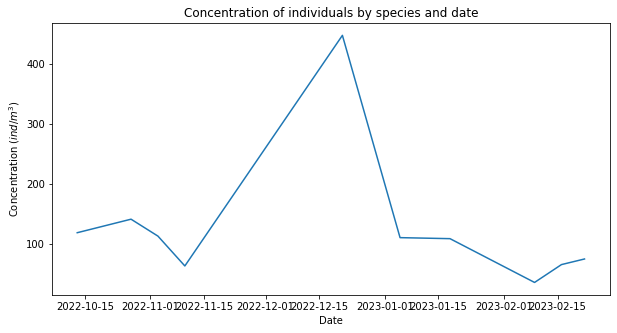

In [36]:
plt.figure(figsize=(10, 5))
sns.lineplot(x="Date", y="Concentration", data=total_conc100, markers=True, ci=None)
plt.title("Concentration of individuals by species and date")
plt.xlabel("Date")
plt.ylabel("Concentration ($ind/m^3$)")
plt.show()

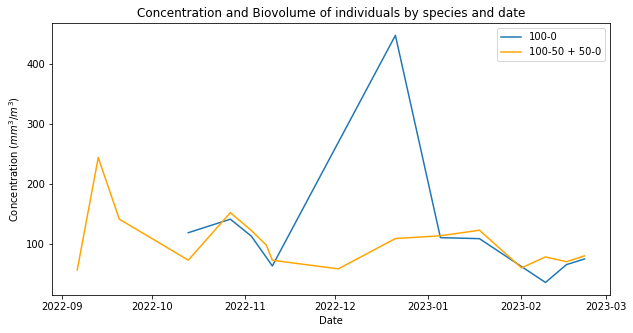

In [37]:
fig, ax1 = plt.subplots(figsize=(10, 5))

# plot the first variable (Concentration) on the left y-axis
sns.lineplot(x="Date", y="Concentration", data=total_conc100, markers=True, ax=ax1, ci=None, label = "100-0")
ax1.set_xlabel('Date')
ax1.set_ylabel('Concentration ($ind/m^3$)')




sns.lineplot(x="Date", y="Concentration", data=total_conc, markers=True, ax=ax1, color='orange', ci=None, label = "100-50 + 50-0")
ax1.set_ylabel('Concentration ($mm^3/m^3$)')

plt.title("Concentration and Biovolume of individuals by species and date")
plt.legend()
plt.show()

In [ ]:
print(total_conc)

         Date  Count  Concentration   Biovolume
0  2022-09-06    403     129.092948   65.448853
1  2022-09-13   1725     817.533171  228.805767
2  2022-09-20    933     552.273539  168.045545
3  2022-10-13    516     145.997793   39.162013
4  2022-10-27   1077     152.363976   28.724381
5  2022-11-03    862     243.895538   78.889627
6  2022-11-08    693     196.078431   49.791068
7  2022-11-10    494     139.773081   33.320948
8  2022-12-02    416      58.851824   11.361934
9  2022-12-21    703     373.626246  115.548937
10 2023-01-05    785     222.115114   46.407411
11 2023-01-18    870     246.166035   49.694396
12 2023-02-01    409     115.726331   29.444464
13 2023-02-09    832     235.413955   76.006165
14 2023-02-16    499     141.187788   39.575200
15 2023-02-22    569     160.993690   39.208669


In [ ]:
print(total_conc100)

        Date  Count  Concentration   Biovolume
0 2022-10-13    841     118.976884   19.194090
1 2022-10-27   1000     141.470730   26.437597
2 2022-11-03    801     113.318054   29.250998
3 2022-11-10    450      63.661828    8.432239
4 2022-12-21    763     447.380828  128.560910
5 2023-01-05    783     110.771581   12.377385
6 2023-01-18    771     109.073933   11.754946
7 2023-02-09    256      36.216507    4.164172
8 2023-02-16    466      65.925360    8.282173
9 2023-02-22    532      75.262428    8.770576


In [ ]:
print(sample_comparison)

         100-0  100-50 + 50-0
0   141.470730     129.092948
1   113.318054     817.533171
2    63.661828     552.273539
3    14.713372     145.997793
4   140.526266     152.363976
5   292.141190     243.895538
6   110.771581     196.078431
7   109.073933     139.773081
8    36.216507      58.851824
9    65.925360     373.626246
10   75.262428     222.115114
11  118.976884     246.166035


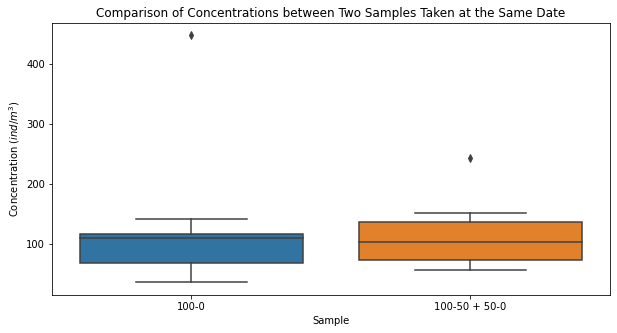

In [38]:
# create a new DataFrame with the concentrations for the two samples taken at each date
sample_comparison = pd.DataFrame()
sample_comparison['100-0'] = total_conc100['Concentration']
sample_comparison['100-50 + 50-0'] = total_conc['Concentration']

# create a grouped box plot to compare the distribution of concentrations between the two samples taken at each date
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=sample_comparison, ax=ax)
ax.set_xlabel('Sample')
ax.set_ylabel('Concentration ($ind/m^3$)')
ax.set_title('Comparison of Concentrations between Two Samples Taken at the Same Date')
plt.show()

In [39]:
merged = pd.merge(total_conc, total_conc100, on='Date', suffixes=('_total', '_total100'))
merged = merged[['Date', 'Concentration_total', 'Concentration_total100']]
merged['Difference'] = merged['Concentration_total'] - merged['Concentration_total100']


In [40]:
merged['Difference'] = abs(merged['Difference'])

In [ ]:
print(merged)

        Date  Concentration_total  Concentration_total100  Difference
0 2022-10-13           145.997793              118.976884   27.020909
1 2022-10-27           152.363976              141.470730   10.893246
2 2022-11-03           243.895538              113.318054  130.577484
3 2022-11-10           139.773081               63.661828   76.111253
4 2022-12-21           373.626246              447.380828   73.754582
5 2023-01-05           222.115114              110.771581  111.343533
6 2023-01-18           246.166035              109.073933  137.092102
7 2023-02-09           235.413955               36.216507  199.197448
8 2023-02-16           141.187788               65.925360   75.262428
9 2023-02-22           160.993690               75.262428   85.731262


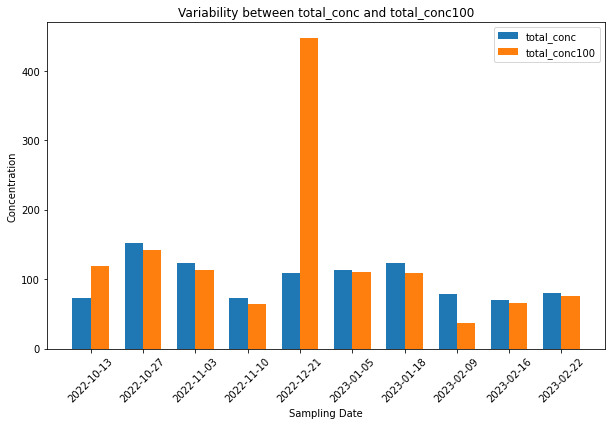

In [41]:
# Set the figure size
plt.figure(figsize=(10, 6))

# Set the x-axis labels
dates = merged['Date'].dt.strftime('%Y-%m-%d').tolist()

# Set the bar width
bar_width = 0.35

# Create the bar plots
plt.bar(range(len(dates)), merged['Concentration_total'], width=bar_width, label='total_conc')
plt.bar([i + bar_width for i in range(len(dates))], merged['Concentration_total100'], width=bar_width, label='total_conc100')

# Set the x-axis tick labels
plt.xticks([i + bar_width/2 for i in range(len(dates))], dates, rotation=45)

# Set the axis labels and title
plt.xlabel('Sampling Date')
plt.ylabel('Concentration')
plt.title('Variability between total_conc and total_conc100')

# Add a legend
plt.legend()

# Show the plot
plt.show()







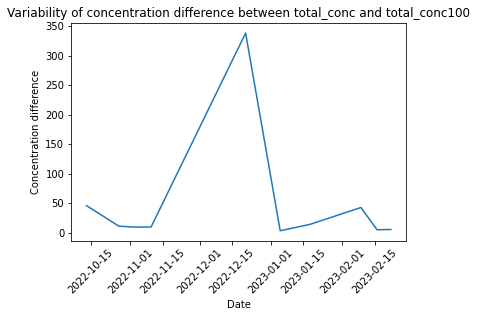

In [42]:
sns.lineplot(x='Date', y='Difference', data=merged)
plt.xticks(rotation=45)
plt.title('Variability of concentration difference between total_conc and total_conc100')
plt.xlabel('Date')
plt.ylabel('Concentration difference')
plt.show()

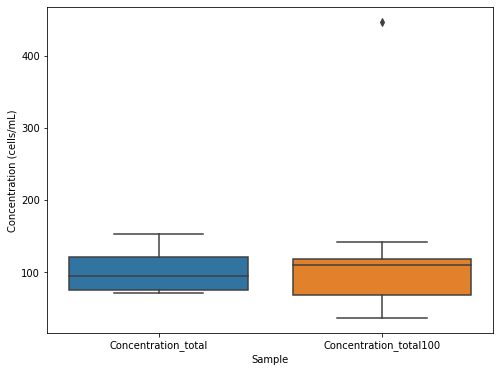

In [43]:

fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(data=merged[['Concentration_total', 'Concentration_total100']].abs(), ax=ax)
ax.set_ylabel('Concentration (cells/mL)')
ax.set_xlabel('Sample')
ax.set_xticklabels(['Concentration_total', 'Concentration_total100'])
plt.show()